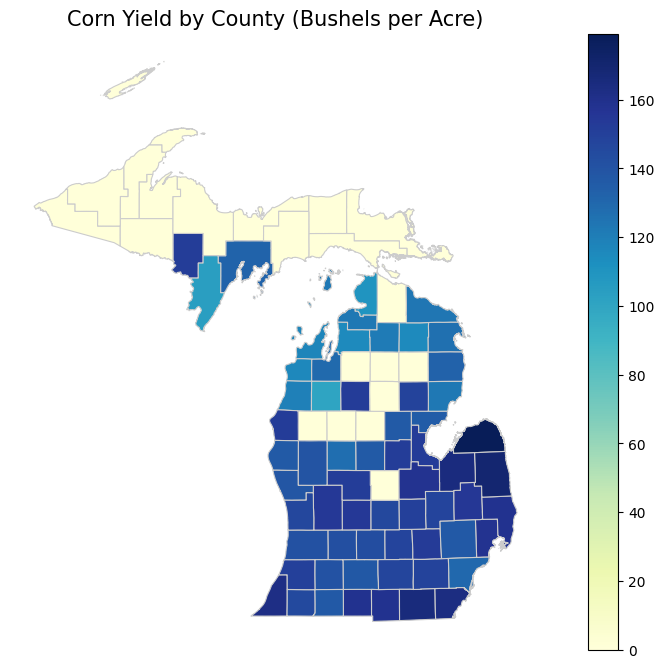

In [14]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the GeoJSON file for county boundaries
gdf = gpd.read_file('County.geojson')

# Step 2: Load the USDA data
usda_data = pd.concat([pd.read_csv(f'data/usda_data_{year}.csv') for year in range(2019, 2021)])

# Step 3: Handle NaN values in the county_ansi column
# Drop rows with NaN values in county_ansi
usda_data = usda_data[usda_data['county_ansi'].notna()]

# Convert county_ansi to an integer, then back to a string (drop the state portion if needed)
usda_data['county_ansi'] = usda_data['county_ansi'].astype(int).astype(str).str.zfill(3)

# Group the USDA data to get the average yield for each county
usda_grouped = usda_data.groupby('county_ansi')['Value'].mean().reset_index()

# Ensure FIPSCode is also a string and in the correct format
gdf['FIPSCode'] = gdf['FIPSCode'].astype(str).str.zfill(3)

# Step 4: Merge USDA data with the GeoJSON data
merged_gdf = gdf.merge(usda_grouped, left_on='FIPSCode', right_on='county_ansi', how='left')

# Check for NaN values and fill with 0
merged_gdf['Value'] = merged_gdf['Value'].fillna(0)

# Step 5: Create a choropleth map of corn yield by county
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='Value', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add titles and labels
plt.title('Corn Yield by County (Bushels per Acre)', fontsize=15)
plt.axis('off')  # Turn off the axis

# Show the plot
plt.show()

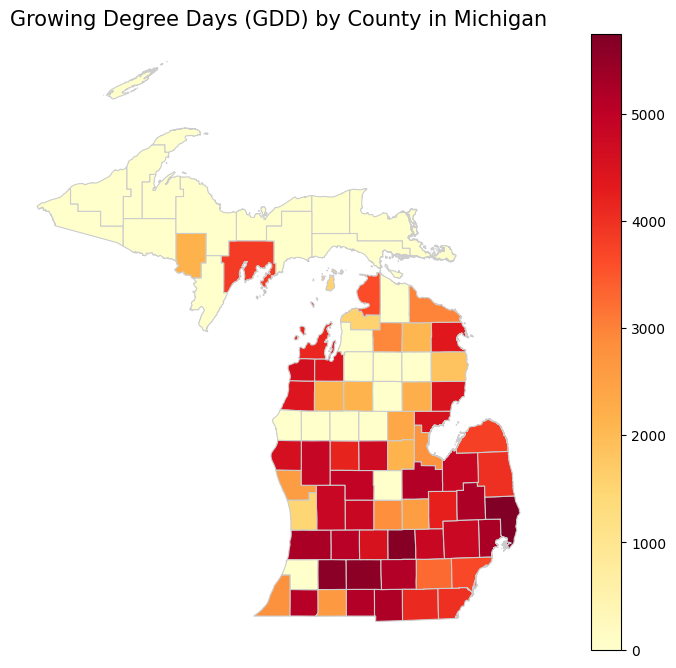

In [15]:
# Step 1: Load the GeoJSON file for county boundaries
gdf = gpd.read_file('County.geojson')

# Step 2: Load the weather data (assuming you have weather data from earlier)
weather_data = pd.concat([pd.read_csv(f'data/weather_data_{year}.csv') for year in range(2019, 2021)])

# Step 3: Calculate GDD for each county
# Assuming 'TMAX' and 'TMIN' are present in the weather data
weather_data['TMAX'] = weather_data['TMAX'].clip(lower=50, upper=86)
weather_data['TMIN'] = weather_data['TMIN'].clip(lower=50)
weather_data['TAVG'] = (weather_data['TMAX'] + weather_data['TMIN']) / 2
weather_data['GDD'] = weather_data['TAVG'] - 50

# Step 4: Group the weather data to calculate total GDD for each county
gdd_grouped = weather_data.groupby('county_ansi')['GDD'].sum().reset_index()

# Convert county_ansi to an integer, then back to a string (drop the state portion if needed)
gdd_grouped['county_ansi'] = gdd_grouped['county_ansi'].astype(int).astype(str).str.zfill(3)

# Ensure FIPSCode is also a string and in the correct format
gdf['FIPSCode'] = gdf['FIPSCode'].astype(str).str.zfill(3)

# Step 5: Merge weather data (GDD) with the GeoJSON data
merged_gdf = gdf.merge(gdd_grouped, left_on='FIPSCode', right_on='county_ansi', how='left')

# Check for NaN values and fill with 0
merged_gdf['GDD'] = merged_gdf['GDD'].fillna(0)

# Step 6: Create a choropleth map of GDD by county
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='GDD', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add titles and labels
plt.title('Growing Degree Days (GDD) by County in Michigan', fontsize=15)
plt.axis('off')  # Turn off the axis

# Show the plot
plt.show()